## Kaggle Overview
The aim of this competition is to develop a model that can detect personally identifiable information (PII) in student texts. By automating this process, the costs associated with releasing educational datasets can be reduced, thus enhancing research in learning sciences and the development of educational tools.

Successful creation of reliable automated methods would allow researchers and industry professionals to exploit large public educational datasets. This could foster the creation of effective tools and interventions that support both educators and students.

## My Goal
My specific task was to construct a solution that did not require an extensive training period, and that could be efficiently trained on either a CPU or GPU environment. Here are the training metrics for the different environments of the final solution:

GPU (T4 GPU): 10 to 13 minutes

CPU: 43 to 45 minutes

This setup ensures the model is accessible and manageable across various hardware platforms.



## Dataset Description
The competition dataset contains approximately 22,000 essays from students in a massively open online course, all responding to the same assignment prompt. This prompt required students to apply course material to a real-world problem. The competition's objective is to annotate personally identifiable information (PII) within these essays. To ensure privacy, actual PII has been replaced with similar surrogate identifiers through a partially automated process. Notably, 70% of the essays constitute the test set, prompting competitors to augment their training data with external, publicly available datasets.




In [21]:
orginal_data = pl.read_json('/content/drive/MyDrive/kaggle_lstm/data/train.json')
orginal_data.head(5)


document,full_text,tokens,trailing_whitespace,labels
i64,str,list[str],list[bool],list[str]
7,"""Design Thinkin…","[""Design"", ""Thinking"", … "" ""]","[true, true, … false]","[""O"", ""O"", … ""O""]"
10,"""Diego Estrada …","[""Diego"", ""Estrada"", … "" ""]","[true, false, … false]","[""B-NAME_STUDENT"", ""I-NAME_STUDENT"", … ""O""]"
16,"""Reporting proc…","[""Reporting"", ""process"", … "" ""]","[true, false, … false]","[""O"", ""O"", … ""O""]"
20,"""Design Thinkin…","[""Design"", ""Thinking"", … "" ""]","[true, true, … false]","[""O"", ""O"", … ""O""]"
56,"""Assignment: V…","[""Assignment"", "":"", … "" ""]","[false, false, … false]","[""O"", ""O"", … ""O""]"



### File and Field Information
The data is formatted in JSON, featuring a document identifier, the full essay text, a token list, whitespace data, and token annotations. Tokens were analyzed using the SpaCy English tokenizer and labeled in BIO (Beginning, Inner, Outer) format:
- •	B-: Prefix indicating the start of a PII entity.
- •	I-: Prefix for tokens continuing a PII entity.
- •	O: Label for tokens that do not represent PII.
Data Challenges


In [22]:
(
  pl.DataFrame({
                'lbl': list(itertools.chain.from_iterable(orginal_data['labels'].to_list()))
              })
  .group_by('lbl')
  .agg(
      summary_count = pl.col('lbl').count()
  )
)


lbl,summary_count
str,u32
"""B-ID_NUM""",78
"""I-NAME_STUDENT…",1096
"""O""",4989794
"""I-URL_PERSONAL…",1
"""B-NAME_STUDENT…",1365
"""B-URL_PERSONAL…",110
"""B-EMAIL""",39
"""B-USERNAME""",6
"""I-STREET_ADDRE…",20


## PII Types
Participants are tasked with labeling the following PII types:
- •	NAME_STUDENT: Any student's full or partial name, excluding names of instructors or other individuals.
- •	EMAIL: A student's email address.
- •	USERNAME: A username belonging to a student on any platform.
- •	ID_NUM: Identifiable numbers or character sequences, like a student ID or social security number.
- •	PHONE_NUM: A phone number linked to a student.
- •	URL_PERSONAL: A URL potentially identifying a student.
- •	STREET_ADDRESS: A student's full or partial street address.

## Data Challenges
The dataset includes about 6,800 essays with nearly 1,000 instances of positive PII tags, highlighting a challenge due to the scarcity of positive labels. Competitors had the option to generate synthetic data or utilize public datasets shared by other participants to address this issue.


## Overview

I wanted to share my small DeBERTa implementation for this competition. The primary goal of my participation was to have fun and explore different approaches.
Initially, I started with a traditional LSTM model and experimented with various embeddings, including PyTorch embeddings and embeddings from the Transformers library. I also attempted to enrich the embeddings with part-of-speech (POS) tags to provide additional syntactic information to the model.<br><br>

However, my best-performing model was a small DeBERTa architecture trained on a mixed dataset. By "mixed dataset," I mean that I augmented the original competition data with additional samples from datasets provided by Moth and Nichloas. I want to express my gratitude to them for making their datasets available, as they significantly contributed to the improvement of my model's performance.Below are the link to the additional Data:

- [Moth](https://www.kaggle.com/datasets/alejopaullier/pii-external-dataset/data)
- [Nichloas](https://www.kaggle.com/datasets/nbroad/pii-dd-mistral-generated)


In [ ]:

import polars as pl
import torch
from transformers.models.deberta_v2 import DebertaV2ForTokenClassification, DebertaV2TokenizerFast
import joblib, pdb, itertools
from functools import partial
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch, os, random
import torch.nn as nn
from transformers import AutoModel
from torch.optim import AdamW
from sklearn.metrics import fbeta_score, precision_score, recall_score
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Config

Below are the details of the config details I settled on that gave me the most optimal score.

In [ ]:
model_directory = "/kaggle/input/deberta-v3-small/deberta_v3_small/"
stride = 100
max_length  = 512
test_path = '/kaggle/input/aug-data/test.joblib'
vali_path = '/kaggle/input/aug-data/vali_.joblib'
train_path = '/kaggle/input/aug-data/train_.joblib'

competition_test = '/kaggle/input/pii-detection-removal-from-educational-data/test.json'


model_ouput = '/kaggle/input/demo-model/demo.pt'


pytorch_seed = 250
batch_size = 3

max_epochs = 2

tokenizer = DebertaV2TokenizerFast.from_pretrained(model_directory, device="cuda")

to_train = False

pii_tags = {
             0: 'O',
             1: 'I-URL_PERSONAL',
             2: 'B-USERNAME',
             3: 'B-NAME_STUDENT',
             4: 'B-STREET_ADDRESS',
             5: 'B-ID_NUM',
             6: 'B-EMAIL',
             7: 'B-URL_PERSONAL',
             8: 'I-PHONE_NUM',
             9: 'B-PHONE_NUM',
             10: 'I-NAME_STUDENT',
             11: 'I-STREET_ADDRESS',
             12: 'I-ID_NUM'
          }

reverser_pii = {j: i for i, j in pii_tags.items()}


num_labels = len(reverser_pii)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Data Preperation

The main logic behind my data preparation involves using an extensive script rather than Hugging Face libraries because I initially aimed for a traditional sequence model and decided to stick with an extensive Polars chain. In this chain, I create a key that aligns with the words, and I reconstruct the string based on the tokens and their leading whitespace.

In [ ]:
def load_data(file_path, train=True):
    df = pl.read_json(file_path).lazy()
    reshaped_df = (
        df
        .with_columns(
            token_keys=pl.col('tokens')
            .map_elements(lambda f: [i for i in range(len(f))]),
        )
        .explode(['tokens', 'trailing_whitespace', 'token_keys'])
        .with_columns(
            token_len=pl.col('tokens').str.len_chars(),
        )
        .with_columns(
            token_len=pl.struct(['token_keys', 'token_len'])
            .map_elements(lambda f: [f['token_keys']] * f['token_len'])
        )
        .with_columns(
            token_len=pl.when(pl.col('trailing_whitespace') == True)
            .then(pl.col('token_len').list.concat(-1))
            .otherwise(pl.col('token_len')),
            tokens_rec=pl.when(pl.col('trailing_whitespace') == True)
            .then(pl.col('tokens').add(' '))
            .otherwise(pl.col('tokens'))
        )
        .group_by('document', maintain_order=True)
        .agg(
            tokens=pl.col('tokens'),
            token_key=pl.col('token_len').flatten(),
            tokens_rec=pl.col('tokens_rec')
        )
        .with_columns(
            token_rec=pl.col('tokens_rec')
            .list.join(separator='')
        )
        .drop('tokens_rec')
    )
    if train:
        temp = ((reshaped_df
                 .join(df.select(['document', 'labels'])
                       , on='document')
                 )
        )
    else:
        temp = reshaped_df
    return temp

Below is my implementation of the tokenizer, I chunked the passages into 512, and then had the overflow turned on, to capture all the overflow.

In [ ]:
def tokenize( a, b, tokenizer=tokenizer,stride = stride, max_length = max_length):
    txt = a.to_list()
    doc = b.to_list()

    inputs = tokenizer(txt ,
                       padding=True,
                       truncation=True,
                       return_offsets_mapping=True,
                       return_overflowing_tokens = True,
                       stride = stride,
                       add_special_tokens=True,
                       max_length= max_length,

                      )

    overflow_to_sample_mapping = inputs["overflow_to_sample_mapping"]

    doc_key = []
    for i, mapping in enumerate(overflow_to_sample_mapping):
        doc_key.append(doc[mapping])

    offset = inputs['offset_mapping']
    attention_mask = inputs['attention_mask']
    input_ids = inputs['input_ids']
    txt_lst = []

    for token_ids in input_ids:
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        txt_lst.append(tokens)

    return {'txt':txt_lst,
            'attention_mask': attention_mask,
            'input_ids':input_ids,
            'offset': offset ,
            'doc': doc_key
           }

Below is my alignment logic that I used to align the provided labels to the sub-words and tokens from the tokenizer.

In [ ]:
def align_lables(row):
    lbl = row['labels']
    offset = row['offset']
    tok_key = row['token_key']
    token_rec = row['token_rec']

    temp_list = []
    for start, end in offset:

        if (start== 0 and end ==0):
            temp_list.append('<PAD>')
            continue
        if tok_key[start] == -1:
            start += 1
        if token_rec[start].isspace():
             start += 1
        temp = tok_key[start]
        temp_list.append(lbl[temp])
    return temp_list

I used a 5-fold cross-validation method to organize my datasets for training, testing, and validation. The entire dataset was divided into five equal parts. In each iteration, one fold was used as the test set to assess the model's performance on unseen data. Another distinct fold was designated as the validation set, which was utilized for parameter tuning and to prevent model overfitting. The remaining three folds were combined to form the training set, where the model learned from the data. Below is my best split.

In [ ]:

%%time
test = joblib.load(test_path)


CPU times: user 126 ms, sys: 239 ms, total: 364 ms
Wall time: 1.16 s


In [ ]:

%%time
vali_ = joblib.load(vali_path)


CPU times: user 130 ms, sys: 239 ms, total: 369 ms
Wall time: 1.12 s


In [ ]:

%%time
train_ = joblib.load(train_path)
train_.head(5)

CPU times: user 153 ms, sys: 722 ms, total: 875 ms
Wall time: 910 ms


document,tokens,token_key,token_rec,labels,db_source
i64,list[str],list[i64],str,list[str],str
7,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 752]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal"""
10,"[""Diego"", ""Estrada"", … "" ""]","[0, 0, … 562]","""Diego Estrada …","[""B-NAME_STUDENT"", ""I-NAME_STUDENT"", … ""O""]","""orginal"""
16,"[""Reporting"", ""process"", … "" ""]","[0, 0, … 728]","""Reporting proc…","[""O"", ""O"", … ""O""]","""orginal"""
20,"[""Design"", ""Thinking"", … "" ""]","[0, 0, … 1070]","""Design Thinkin…","[""O"", ""O"", … ""O""]","""orginal"""
86,"[""Cheese"", ""Startup"", … "" ""]","[0, 0, … 441]","""Cheese Startup…","[""O"", ""O"", … ""O""]","""orginal"""


Below is a distribution of the data based on the source, which includes the original dataset, Moth, and Nicholas Data.

/tmp/ipykernel_34/252925993.py:4: DeprecationWarning: `aggregate_function='count'` input for `pivot` is deprecated. Please use `aggregate_function='len'`.
  (


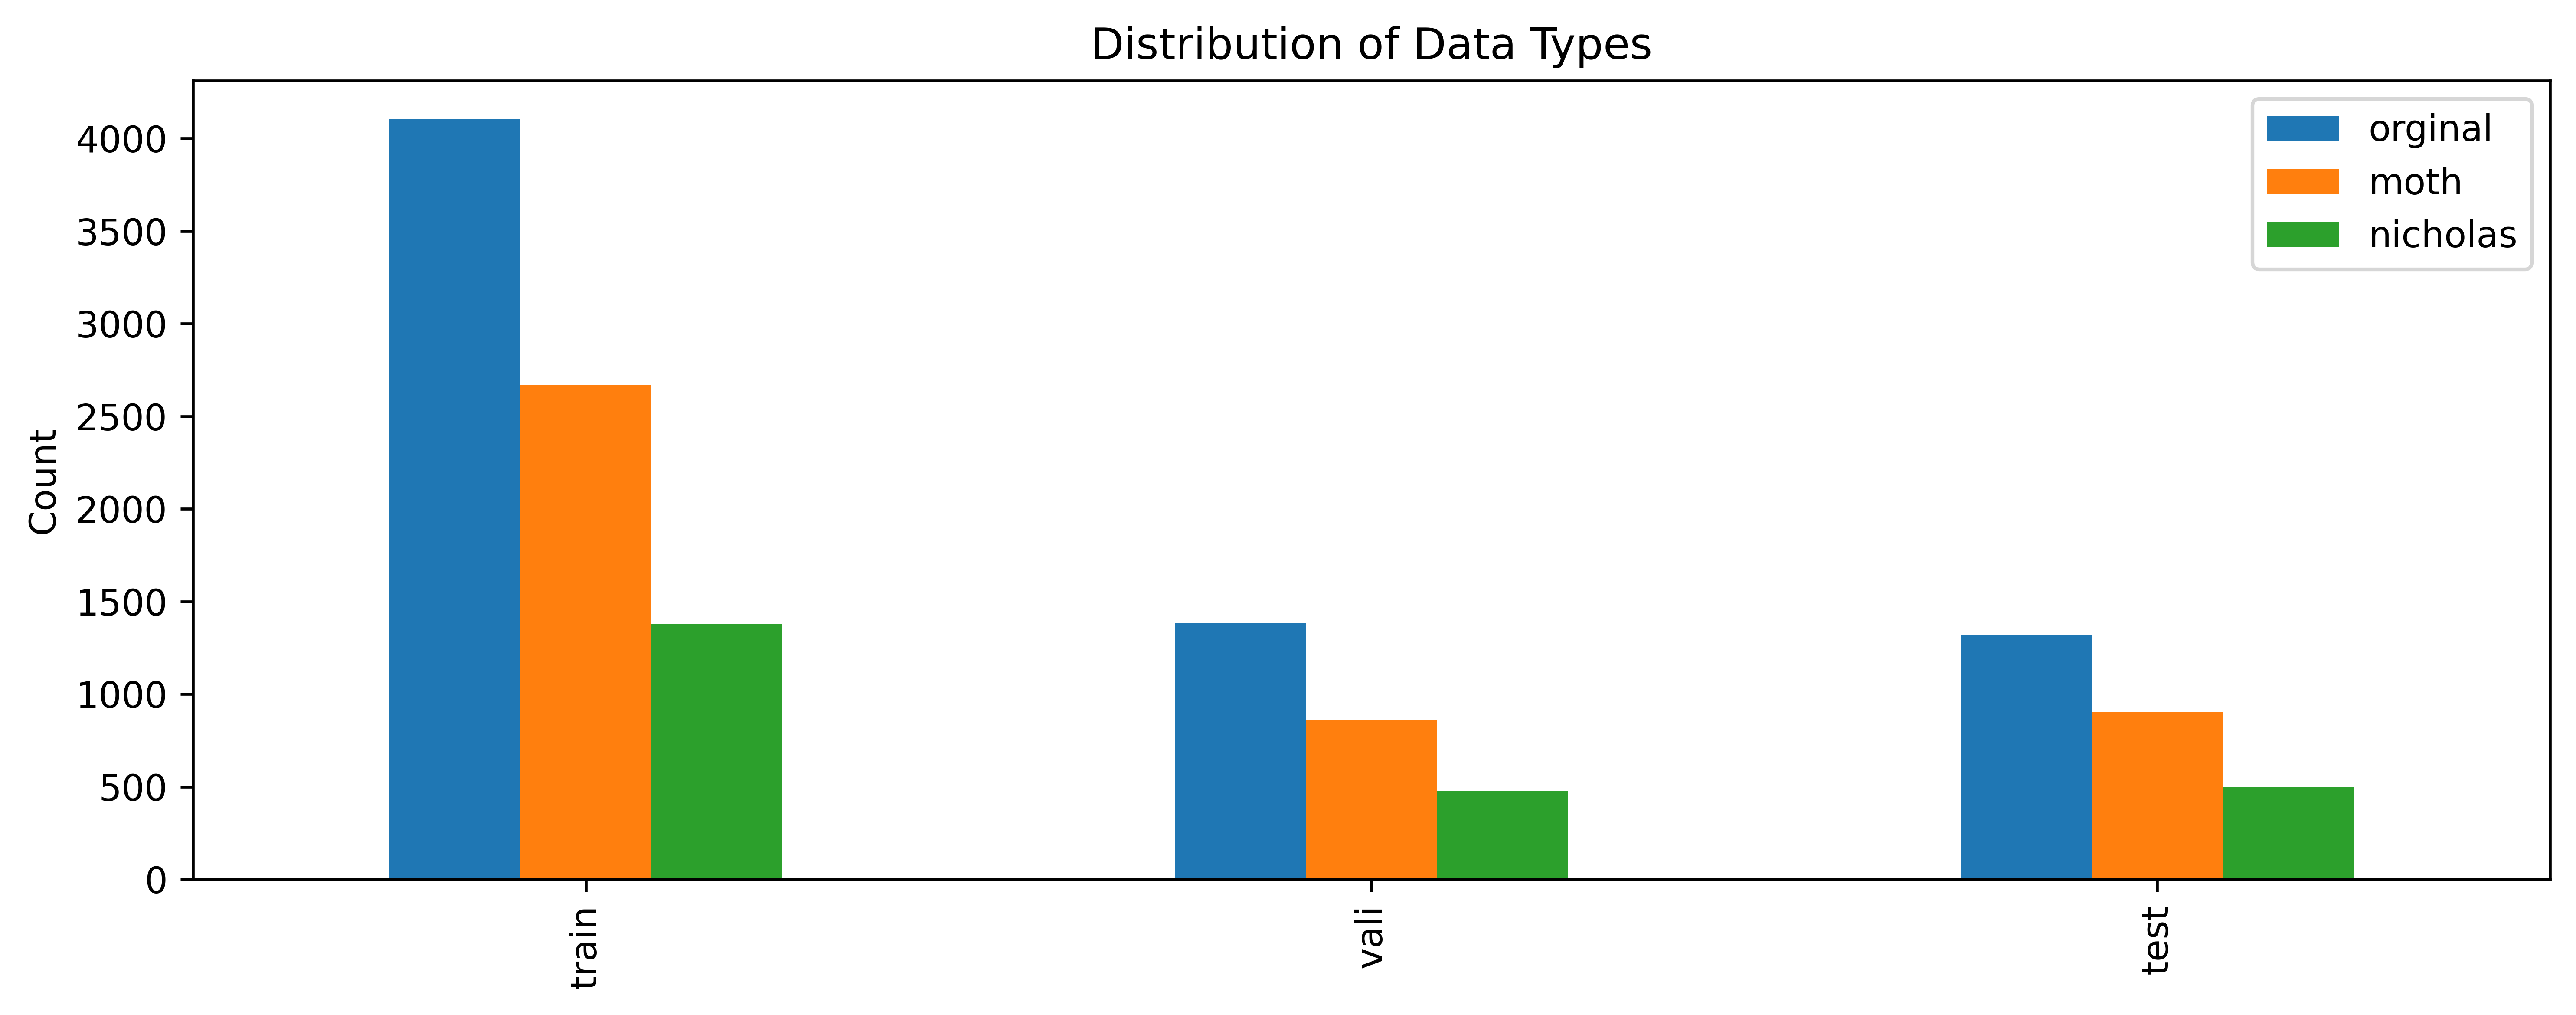

In [ ]:
fig, ax = plt.subplots(dpi = 600, figsize =(10,4) )

(
  (
  pl.concat([

      train_.with_columns(type_ = pl.lit('train')),
      vali_.with_columns(type_ = pl.lit('vali')),
      test.with_columns(type_ = pl.lit('test'))

  ], how = 'vertical_relaxed'
  )
  .select(pl.col('type_'), pl.col('db_source'))
  .with_columns(
      count = pl.lit(1)
  )
  )
  .pivot(values ='count', columns = 'db_source', index = 'type_', aggregate_function = "count")
  .to_pandas()
  .set_index('type_')
  .plot
  .bar(ax = ax)

)

ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('Distribution of Data Types')

plt.tight_layout()
plt.show()

In [ ]:
def create_summary(df):
  return (df
 .lazy()
 .explode(pl.col('labels'))
 .filter(pl.col('labels') !="O")
 .select(['db_source', 'labels'])

 .group_by(['labels', 'db_source'])
 .agg(
     count = pl.col('db_source').count()

 )
 .with_columns(
      total=pl.sum('count').over('labels')

 )
.with_columns(
    percentage=pl.col('count') / pl.col('total')
)

 .collect()
 .pivot(values = ['count'],
        columns = 'db_source',
        index = 'labels',
        aggregate_function = "sum"
        )
 .fill_null(0)
 .sort('labels')
)



In [ ]:
#train
#details of the the train Data.
create_summary(train_)


labels,orginal,moth,nicholas
str,u32,u32,u32
"""B-EMAIL""",17,2295,1447
"""B-ID_NUM""",48,0,1396
"""B-NAME_STUDENT…",817,6744,3489
"""B-PHONE_NUM""",5,1438,1415
"""B-STREET_ADDRE…",1,2103,1345
"""B-URL_PERSONAL…",59,367,1964
"""B-USERNAME""",6,421,1409
"""I-ID_NUM""",1,0,580
"""I-NAME_STUDENT…",629,3387,4367


In [ ]:
#validation
#details of the the Validation Data.
create_summary(vali_)


labels,orginal,moth,nicholas
str,u32,u32,u32
"""B-EMAIL""",14,732,484
"""B-ID_NUM""",18,0,486
"""B-NAME_STUDENT…",275,2080,1203
"""B-PHONE_NUM""",0,484,482
"""B-STREET_ADDRE…",0,704,466
"""B-URL_PERSONAL…",23,116,663
"""B-USERNAME""",0,146,472
"""I-ID_NUM""",0,0,259
"""I-NAME_STUDENT…",244,1100,1525


In [ ]:
#test
#details of the test Data
create_summary(test)


labels,orginal,nicholas,moth
str,u32,u32,u32
"""B-EMAIL""",8,517,767
"""B-ID_NUM""",12,494,0
"""B-NAME_STUDENT…",273,1245,2280
"""B-PHONE_NUM""",1,491,497
"""B-STREET_ADDRE…",1,483,736
"""B-URL_PERSONAL…",28,670,137
"""B-USERNAME""",0,493,151
"""I-ID_NUM""",0,220,0
"""I-NAME_STUDENT…",223,1567,1180


In [ ]:
def train_lbl(df):
    return (df.join(
                (
                (pl.DataFrame(tokenize( df['token_rec'], df['document'])))
                .rename({'doc': 'document'})),on = 'document'
                )
                .with_columns(
                    align_labels = pl.struct(['labels', 'offset', 'token_key', 'token_rec'])
                                     .map_elements(lambda f: align_lables(f))
                )
               .lazy()
            )

In [ ]:
def test_lbl(df):
    return  (df.join(
                (
                (pl.DataFrame(tokenize( df['token_rec'], df['document'])))
                .rename({'doc': 'document'})),on = 'document'
                )
                .lazy()
             )

In [ ]:
%%time
#this is the actual step of doing tokenization and aligning the lables.
test = test_lbl(test)


CPU times: user 46.8 s, sys: 1.78 s, total: 48.6 s
Wall time: 42.4 s


## Dataset
The custom dataset implementation converts tokens and attention masks into tensors, and also maps labels to their numerical representations using the specified dictionary. Special characters and padding are assigned a value of -100.

In [ ]:
class PIIDataset(Dataset):
    def __init__(self, data, label_to_idx= None):

        self.label_to_idx = label_to_idx #reverse lables in the dict is used
        self.data = data


    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        input_tensors = torch.tensor(self.data[idx, 'input_ids'].to_numpy(), dtype=torch.long)
        attention_tensors = torch.tensor(self.data[idx, 'attention_mask'].to_numpy(), dtype=torch.long)
        if self.label_to_idx is not None:
            labels_tensor = torch.tensor(self.data[idx, 'align_labels']
                                         .map_elements(lambda f: self.label_to_idx.get(f, -100)).to_numpy()
                                        , dtype=torch.long)

            return input_tensors, attention_tensors, labels_tensor

        return input_tensors, attention_tensors

In [ ]:

# my generic early stopping

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_loss - self.delta:
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        self.best_loss = val_loss

    def load_checkpoint(self, model):
        model.load_state_dict(torch.load(self.path))
        return model

## Model

The SmallDeberta class in PyTorch encapsulates a streamlined model leveraging the small DeBERTa architecture, it takes parameters such as the name of a pre-trained samll DeBERTa model, the number of labels for classification, and a dropout rate to avoid overfitting.

During the forward pass, input ids and attention masks guide the data through the small DeBERTa layers to produce base representations, which are then refined by dropout and shaped by the classifier into raw predictions or logits.

If labels are provided for training, the model computes cross-entropy loss, focusing on active inputs as designated by the attention mask and ignoring padding or special tokens (labeled as -100).

In [ ]:
class SmallDeberta(nn.Module):
    def __init__(self, bert_model_name, num_labels, dropout=0.3):
        super(SmallDeberta, self).__init__()
        self.num_labels = num_labels
        self.bert = AutoModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):

        outputs = self.bert(input_ids, attention_mask=attention_mask)
        sequence_output = self.dropout(outputs.last_hidden_state)

        logits = self.classifier(sequence_output)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
                active_loss,
                labels.view(-1),
                torch.tensor(loss_fct.ignore_index).type_as(labels)
            )
            loss = loss_fct(active_logits, active_labels)

            return loss, logits
        else:
            return logits

In [ ]:
test_ds = PIIDataset(data=test.collect())
torch.manual_seed(pytorch_seed)
np.random.seed(pytorch_seed)
test_loader = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
model = SmallDeberta(bert_model_name=model_directory,
                          num_labels=num_labels)
model.to(device)
early_stopping = EarlyStopping(patience=5,
                               verbose=True,
                               delta=0.001,
                               path=model_ouput
                              )
optimizer = AdamW(model.parameters(), lr=5e-5)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
if to_train:
  for epoch in range(max_epochs):
      model.train()
      train_loss = 0

      for batch in train_loader:
          input_ids, attention_mask, labels = (b.to(device) for b in batch)
          loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()


      model.eval()
      val_loss = 0
      with torch.no_grad():
          for batch in val_loader:
              input_ids, attention_mask, labels = (b.to(device) for b in batch)

              loss, _ = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
              val_loss += loss.item()

      train_loss /= len(train_loader)
      val_loss /= len(val_loader)

      early_stopping(val_loss, model)
      if early_stopping.early_stop:
          print("Early stopping triggered.")
          break
      print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
model.load_state_dict(torch.load(model_ouput))

<All keys matched successfully>

My Training loop used for predictions

In [ ]:

def predict(test_loader):
  model.eval()
  predictions = []

  with torch.no_grad():
      for batch in test_loader:
          input_ids, attention_mask = (b.to(device) for b in batch[:2])
          logits = model(input_ids=input_ids, attention_mask=attention_mask)
          probs = torch.softmax(logits, dim=-1)
          predictions_batch = torch.argmax(probs , dim=-1)
          batch_predictions = predictions_batch.cpu().tolist()

          predictions.append(batch_predictions)
  return predictions




In [ ]:
  predictions = predict(test_loader)

The map_offset function takes an input and processes the data to create a new list of dictionaries. It extracts relevant information , such as offset, token_key, predictions, tokens, token_rec, document, and idx. The function then iterates over the offset pairs and uses the token_key values to create a new dictionary dic. Each entry in dic is a dictionary containing the words_, pred (predicted PII tag), idx, and doc values for a specific key_. Finally, the function returns a list of dictionaries, where each dictionary contains the keys and the corresponding values from dic.


In [ ]:

def map_offset(r):
    off = r['offset']
    keys = r['token_key']
    pred = r['predictions']
    tokens = r['tokens']
    token_rec = r['token_rec']
    doc = r['document']
    idx = r['idx']


    dic = {}
    for a,(i, j) in enumerate(off):
        start = i
        if i== 0 and j == 0:
            continue
        if keys[i] == -1:
            start += 1

        if token_rec[i].isspace():
            start += 1


        key_ = keys[start]
        if key_ not in dic:
            dic[key_] = {'words_': tokens[key_],
                         'pred': pii_tags[pred[a]],
                         'idx': idx,
                         'doc': doc
                        }
    return [{'keys': keys, **pred}for keys, pred in dic.items()]

In [ ]:

def all_pred_df_results(test, predictions):
  return (
      test
      .select(['document', 'tokens', 'token_key', 'offset', 'token_rec'])
      .with_columns(
          idx = pl.col('document').cum_count().over('document'),
          predictions = pl.Series(itertools.chain.from_iterable(predictions))
      )
      .with_columns(
          align_pred = pl.struct(['offset',
                                  'token_key',
                                  'predictions',
                                  'token_rec',
                                  'tokens',
                                  'idx',
                                  'document'])
                        .map_elements(lambda f: map_offset(f))
      )
  )



Below is my raw predicted results on my test fold. With my alignment to the orginal tokens.





In [ ]:

all_pred_df = all_pred_df_results(test, predictions)


In [ ]:

remapped_pred = (
                    (pl.LazyFrame(list(itertools
                        .chain.from_iterable(all_pred_df.collect()['align_pred']
                                           .to_list()
                                          )
                             )
                        )
                    .drop('idx')
                    .unique(subset = ['doc', 'keys'],
                            keep ='last',
                            maintain_order=True)

                   )
                    .filter(pl.col('pred') != "O")
                    .with_row_index()
                    .rename({
                        'keys': 'token',
                        'doc': 'document',
                        'pred': 'label'
                    })
               )



In [ ]:
remapped_pred.collect()


index,token,words_,label,document
u32,i64,str,str,i64
0,783,"""Claudia""","""B-NAME_STUDENT…",269
1,784,"""Sarria""","""I-NAME_STUDENT…",269
2,785,""".""","""I-NAME_STUDENT…",269
3,0,"""Maud""","""B-NAME_STUDENT…",308
4,1,"""Dias""","""I-NAME_STUDENT…",308
5,0,"""Wilson""","""B-NAME_STUDENT…",651
6,1,"""Syafinaz""","""I-NAME_STUDENT…",651
7,0,"""Madina""","""B-NAME_STUDENT…",659
8,1,"""Eno""","""I-NAME_STUDENT…",659


My scoring on the entire test fold.


In [ ]:
scoring_ = (
      (test
      .select(['document', 'tokens', 'labels'])
      .unique(subset=['document'], maintain_order = True)
      .explode(['tokens', 'labels'])
      .with_columns(
          token = pl.col('document').cum_count()
                    .over('document')
                    .cast(pl.Int64)
                    .sub(1)
      )
      )
          .join(
          remapped_pred
          ,on = ['document', 'token']
      )
      .filter((pl.col('labels') != 'O') | (pl.col('label') != 'O'))
      .with_columns(
          y = pl.col('labels').map_elements(lambda f: reverser_pii.get(f) ),
          y_hat = pl.col('label').map_elements(lambda f: reverser_pii.get(f) )
      )

  )


In [ ]:
scoring = scoring_.collect()

In [ ]:
# quick view of all the wrong predictions
scoring.filter(pl.col('y') != pl.col('y_hat'))


document,tokens,labels,token,index,words_,label,y,y_hat
i64,str,str,i64,u32,str,str,i64,i64
269,""".""","""O""",785,2,""".""","""I-NAME_STUDENT…",0,10
5233,"""’s""","""O""",2,113,"""’s""","""I-NAME_STUDENT…",0,10
5397,""")""","""O""",18,116,""")""","""B-EMAIL""",0,6
6622,"""Carolina""","""O""",6,169,"""Carolina""","""B-NAME_STUDENT…",0,3
6622,"""Chavez""","""O""",7,170,"""Chavez""","""I-NAME_STUDENT…",0,10
8344,"""Janet""","""O""",7,222,"""Janet""","""B-NAME_STUDENT…",0,3
8344,"""Galletti""","""O""",8,223,"""Galletti""","""I-NAME_STUDENT…",0,10
8842,"""Ingram""","""O""",10,251,"""Ingram""","""I-NAME_STUDENT…",0,10
8935,"""John""","""O""",0,254,"""John""","""B-NAME_STUDENT…",0,3


In [ ]:

def confusion(scoring):
  labels = sorted(scoring[:, 'labels'].unique().to_list())


  cm = confusion_matrix(scoring[:, 'labels'].to_list(),
                        scoring[:, 'label'].to_list(),
                        labels=labels,
                        )
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  ax = disp.ax_
  plt.xticks(range(len(labels)), labels, rotation=90, ha='right')
  plt.subplots_adjust(bottom=0.2)
  plt.show()



Overview of the classification of the entire test fold despite the source


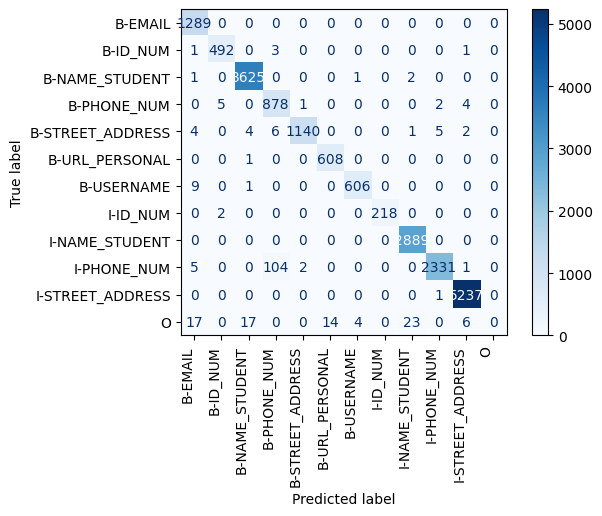

In [ ]:
confusion(scoring)

In [ ]:
overall_f5 = fbeta_score(scoring['y'].to_list(),
            scoring['y_hat'].to_list(),
            beta=5,
            average='micro')
overall_f5

0.987220773909932

In [ ]:
def filter_df(condition, scoring = scoring):
  return (test
       .select(pl.col('document', 'db_source'))
       .unique(subset = 'document')
       ).join(
    scoring.lazy()
    ,on = 'document'
 ).filter(pl.col('db_source') == condition).collect()


In [ ]:
## overview of the orginal data scoring only

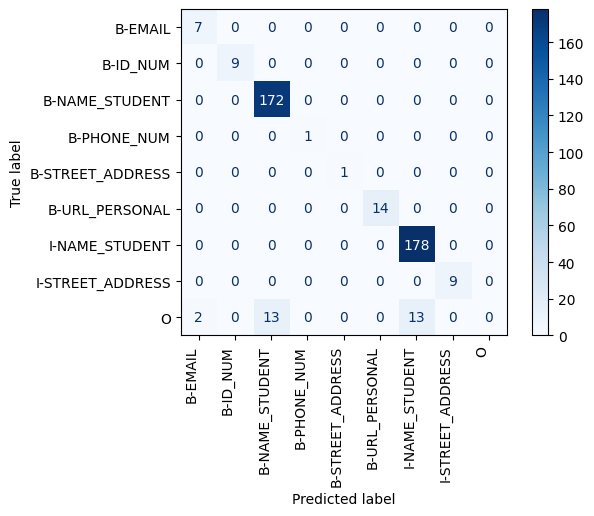

In [ ]:
original =filter_df('orginal')
confusion(original)

In [ ]:
fbeta_score(original['y'].to_list(),
            original['y_hat'].to_list(),
            beta=5,
            average='micro')

0.9331742243436755

In [ ]:
#overview of the moth data scoring only

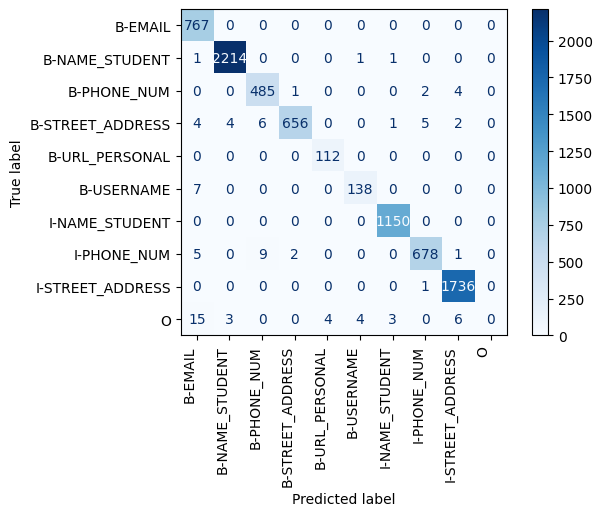

In [ ]:
moth =filter_df('moth')
confusion(moth)

In [ ]:
fbeta_score(moth['y'].to_list(),
            moth['y_hat'].to_list(),
            beta=5,
            average='micro')

0.9884169884169884

In [ ]:
#overview of the nick data scoring only

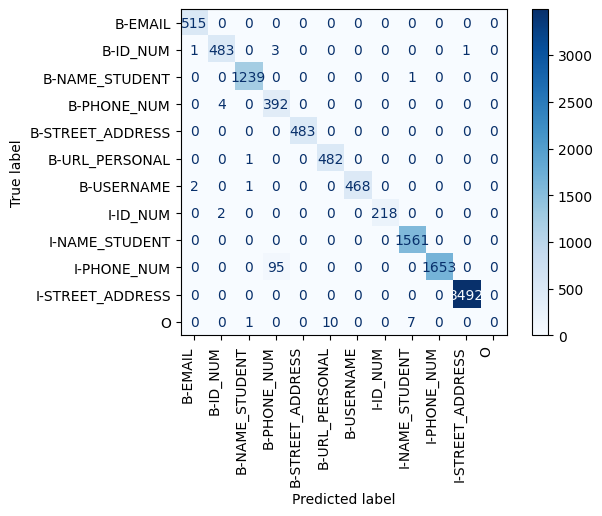

In [ ]:
nick =filter_df('nicholas')
confusion(nick)

In [ ]:
fbeta_score(nick['y'].to_list(),
            nick['y_hat'].to_list(),
            beta=5,
            average='micro')

0.9883940620782725

Overall the model preforms well on the augmented data, but not so well on the original data.Using this approach, my best submission scored was 89.98. Thanks

